# Notebook to explore patient data

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt

### Read in left and right data 

In [82]:
p = 3

if(p==1):
    # patient 1
    left_path = "Test_data/1_1717404766904_walk_Left.csv"
    right_path = "Test_data/1_1717404766904_walk_Right.csv"
elif(p==2):
    # patient 2
    left_path = "Test_data/2_1717405593622_walk_Left.csv"
    right_path = "Test_data/2_1717405593622_walk_Right.csv"
elif(p==3):
    # patient 3
    left_path = "Test_data/3_1717406334094_walk_Left.csv"
    right_path = "Test_data/3_1717406334094_walk_Right.csv"

left_df = pd.read_csv(left_path)
right_df = pd.read_csv(right_path)

print(right_df.head(5))

   PacketCounter  SampleTimeFine    Quat_W    Quat_X    Quat_Y    Quat_Z  \
0              1      1863705331  0.653607  0.128506 -0.680400  0.305515   
1              2      1863721998  0.653524  0.128040 -0.680676  0.305275   
2              3      1863738665  0.653592  0.127317 -0.680687  0.305406   
3              4      1863755332  0.653984  0.126543 -0.680377  0.305580   
4              5      1863771999  0.654703  0.125660 -0.679860  0.305555   

      Acc_X     Acc_Y     Acc_Z     Gyr_X     Gyr_Y    Gyr_Z   
0 -0.017299  0.033384  0.044669 -0.031172  0.023997 -0.078027  
1  9.592815 -2.500930  0.395994 -3.028331  3.209675  2.242578  
2  9.584873 -2.489146  0.440653 -3.425302  4.030447  2.026458  
3  9.610559 -2.473195  0.490130 -3.799568  4.873733  1.745231  
4  9.577432 -2.462649  0.502194 -5.086004  5.782253  1.536769  


### read acceleration values

In [83]:
 def vector_magnitude(*args):
    n = len(args[0])
    assert all(len(x) == n for x in args), "Vectors have different lengths"
    vm = np.sqrt(sum(x ** 2 for x in args))
    return vm

In [84]:
left_pc = left_df["PacketCounter"]
left_acc_x = left_df["Acc_X"].to_numpy() / 9.80665
left_acc_y = left_df["Acc_Y"].to_numpy() / 9.80665
left_acc_z = left_df["Acc_Z"].to_numpy() / 9.80665
left_mag = vector_magnitude(left_acc_x, left_acc_y, left_acc_z)

right_pc = right_df["PacketCounter"]
right_acc_x = right_df["Acc_X"].to_numpy() / 9.80665
right_acc_y = right_df["Acc_Y"].to_numpy() / 9.80665
right_acc_z = right_df["Acc_Z"].to_numpy() / 9.80665

right_mag = vector_magnitude(right_acc_x, right_acc_y, right_acc_z)

### Graph Left acceleration

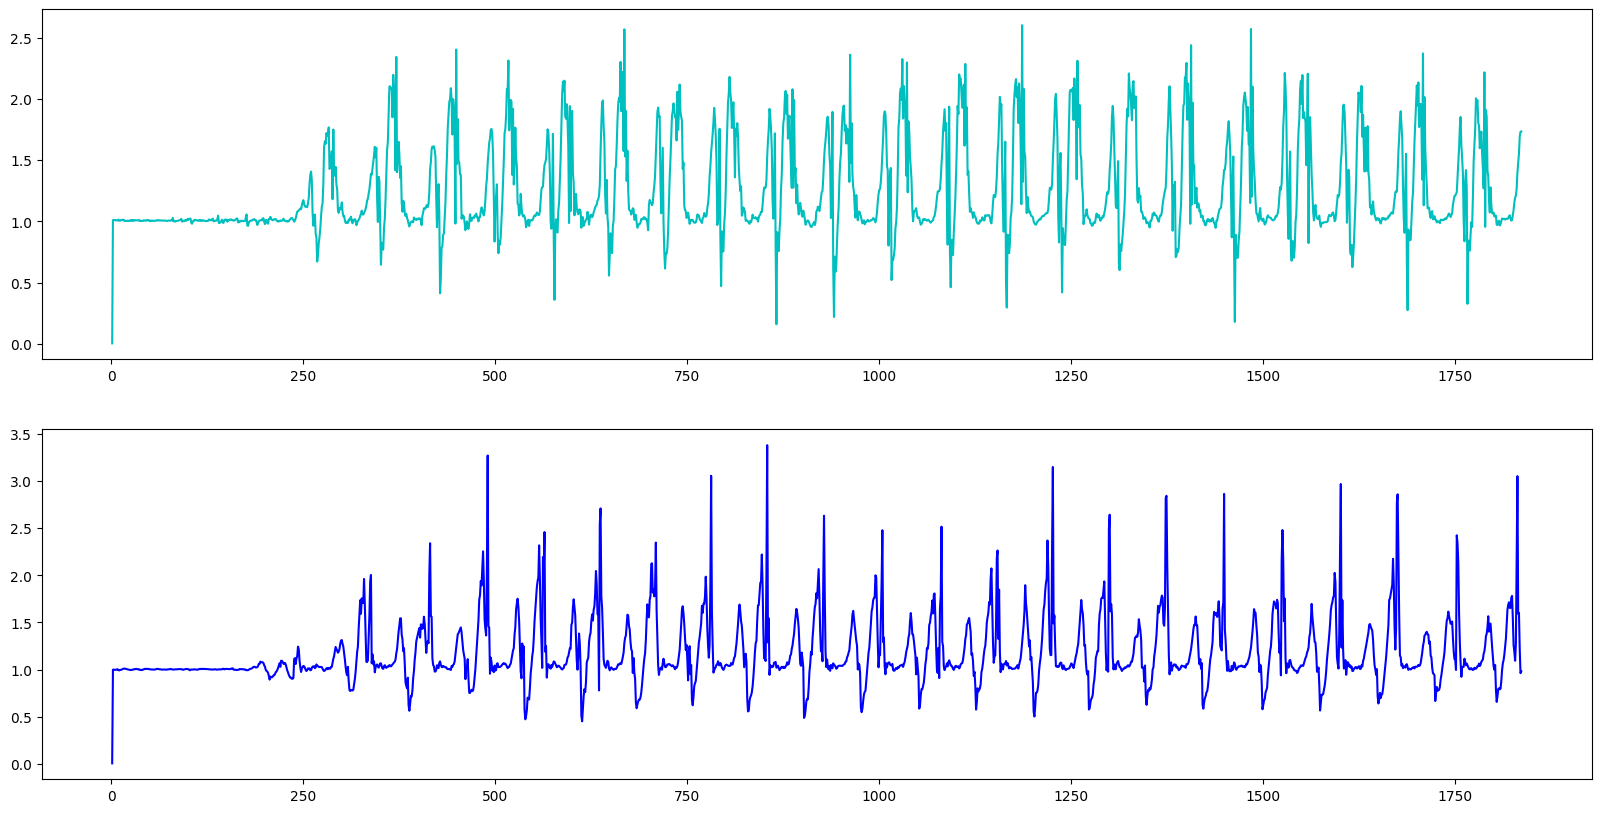

In [85]:
# simple graphs
fig, ax = plt.subplots(2,1, figsize=(20, 10))

ax[0].plot(right_pc, right_mag, color="c")
ax[1].plot(left_pc, left_mag, color="blue")

### Compute loading intensity

remove the first block from the data set

In [86]:
# functions for visibility that are in the compute_loading_intensity module
# pass in 3 sensors
def vector_magnitude(vectors):
    n = len(vectors[0])
    assert all(len(v) == n for v in vectors), "Vectors have different lengths"
    vm = np.sqrt(sum(v ** 2 for v in vectors))
    return vm

def build_filter(frequency, sample_rate, filter_type, filter_order):
    nyq = 0.5 * sample_rate

    if filter_type == "bandpass":
        nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1], btype=filter_type, analog=False, output='ba', fs=sample_rate)
    else:
        nyq_cutoff = frequency / nyq

    return b, a

def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)
    

def compute_fft_mag(data):
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(data)))))
    #print(fftpoints)
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) / (fftpoints/2)
    return mag.tolist()


def compute_loading_intensity(fft_magnitudes, sampling_frequency, high_cut_off):
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(fft_magnitudes)))))
    LI = 0
    fs = sampling_frequency
    fc = high_cut_off
    kc = int((fftpoints/fs)* fc) + 1

    magnitudes = fft_magnitudes

    f = []
    for i in range(0, int(fftpoints/2)+1):
        f.append((fs*i)/fftpoints)

    for k in range(0, kc):
        LI = LI + (magnitudes[k] * f[k])

    return LI


# computes the loading intensity in chunks
def compute_weight_bearing(accel_x, accel_y, accel_z, sampling_rate, time_window, lc_off, hc_off, filter_order, filter_type):
    # build the filter
    b,a = build_filter((lc_off, hc_off), sampling_rate, filter_type, filter_order)
    
    accel_x = accel_x.to_numpy()  / 9.80665
    accel_y = accel_y.to_numpy()  / 9.80665
    accel_z = accel_z.to_numpy()  / 9.80665
    
    window_samples = time_window * sampling_rate
    
    # chunk the data
    a_x = [accel_x[i:i + window_samples] for i in range(0, len(accel_x), window_samples)]
    a_y = [accel_y[i:i + window_samples] for i in range(0, len(accel_y), window_samples)]
    a_z = [accel_z[i:i + window_samples] for i in range(0, len(accel_z), window_samples)]

    # for each chunk
    li = []
    for idx, chunk in enumerate(a_x):
        a_mag = vector_magnitude([chunk, a_y[idx], a_z[idx]])
        filtered_mag = filter_signal(b,a, a_mag, "filtfilt")
        fft_mag = compute_fft_mag(filtered_mag)
        li_result = compute_loading_intensity(fft_mag, sampling_rate, hc_off)
        li.append(li_result)
        
    return li

def fft_graph_values(fft_mags, sample_rate):
    T = 1/sample_rate
    N_r =len(fft_mags)//2
    x = np.linspace(0.0, 1.0/(2.0*T), len(fft_mags)//2).tolist()
    y = fft_mags[:N_r]
    
    return [x,y]

def compute_frequency_response(data, sampling_rate):
    fft_mag = compute_fft_mag(data)
    graph = fft_graph_values(fft_mag, sampling_rate)
    return graph


In [87]:
# variables
sampling_rate = 60 # 60 hz
low_cut_off = 0.1
high_cut_off = 6
filter_order = 5
filter_type = "bandpass"
window = 3 # 5 seconds

b,a = build_filter((low_cut_off, high_cut_off), sampling_rate, filter_type, filter_order)

In [88]:

left_acc_x = left_df["Acc_X"]
left_acc_y = left_df["Acc_Y"]
left_acc_z = left_df["Acc_Z"]
right_acc_x = right_df["Acc_X"]
right_acc_y = right_df["Acc_Y"]
right_acc_z = right_df["Acc_Z"]

wb_left =  compute_weight_bearing(
                           left_acc_x, 
                           left_acc_y, 
                           left_acc_z, 
                           sampling_rate, window, low_cut_off, high_cut_off, filter_order, filter_type)
wb_right = compute_weight_bearing(
                           right_acc_x, 
                           right_acc_y, 
                           right_acc_z, 
                           sampling_rate, window, low_cut_off, high_cut_off, filter_order, filter_type)

### Graph the loading intensity

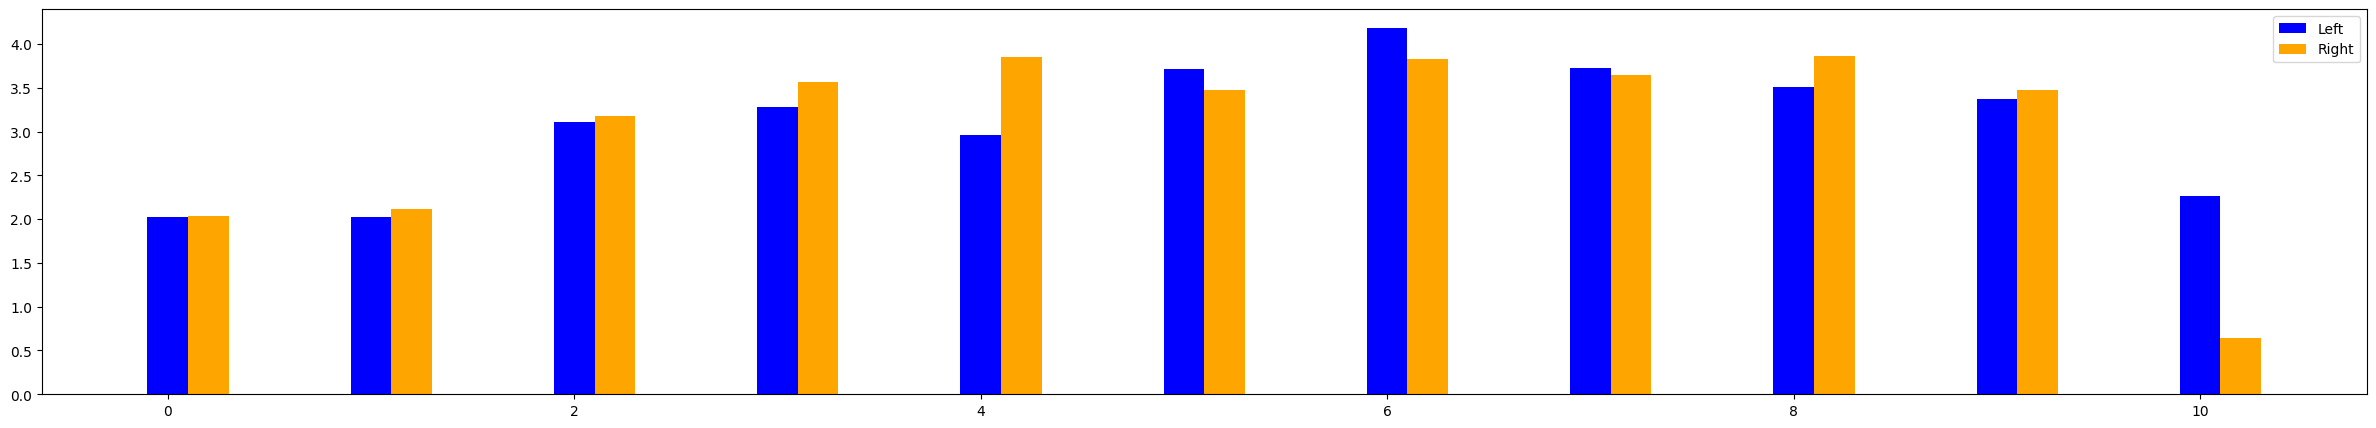

In [89]:
fig, ax = plt.subplots(1,1, figsize=(30, 5))

# time index
l_index = [i for i in range(len(wb_left))]
r_index = [i + 0.2 for i in range(len(wb_right))]

ax.bar(l_index, wb_left,   0.2,  color="blue", label="Left" )
ax.bar(r_index, wb_right,  0.2, color="orange", label="Right" )
ax.legend()

### Compute axis contribution

Z axis is forward (anterior posterior)
X axis is up (vertical)
Y axis is side (medio lateral)

In [90]:
def compute_weight_bearing_for_axis(axis,sampling_rate, time_window, lc_off, hc_off, filter_order, filter_type):
    # build the filter
    b,a = build_filter((lc_off, hc_off), sampling_rate, filter_type, filter_order)
    
    axis = axis.to_numpy()  / 9.80665
    
    window_samples = time_window * sampling_rate
    
    # chunk the data
    axis_chunks = [axis[i:i + window_samples] for i in range(0, len(axis), window_samples)]
    
    # for each chunk
    li = []
    for idx, chunk in enumerate(axis_chunks):
        filtered_mag = filter_signal(b,a, chunk, "filtfilt")
        fft_mag = compute_fft_mag(filtered_mag)
        li_result = compute_loading_intensity(fft_mag, sampling_rate, hc_off)
        li.append(li_result)
        
    return li

In [91]:
left_axis = [ left_df["Acc_X"],  left_df["Acc_Y"], left_df["Acc_Z"] ]
right_axis = [ right_df["Acc_X"],  right_df["Acc_Y"], right_df["Acc_Z"] ]

# all axis left
l_axis_wb = []
for axis in left_axis:
    l_axis_wb.append(compute_weight_bearing_for_axis(axis,
                sampling_rate, window, low_cut_off, high_cut_off, filter_order, filter_type) )

r_axis_wb = []
for axis in right_axis:
    r_axis_wb.append(compute_weight_bearing_for_axis(axis,
                sampling_rate, window, low_cut_off, high_cut_off, filter_order, filter_type) )

print(len(l_axis_wb[0]), len(r_axis_wb[0]))

11 11


Text(0, 0.5, 'BW/s')

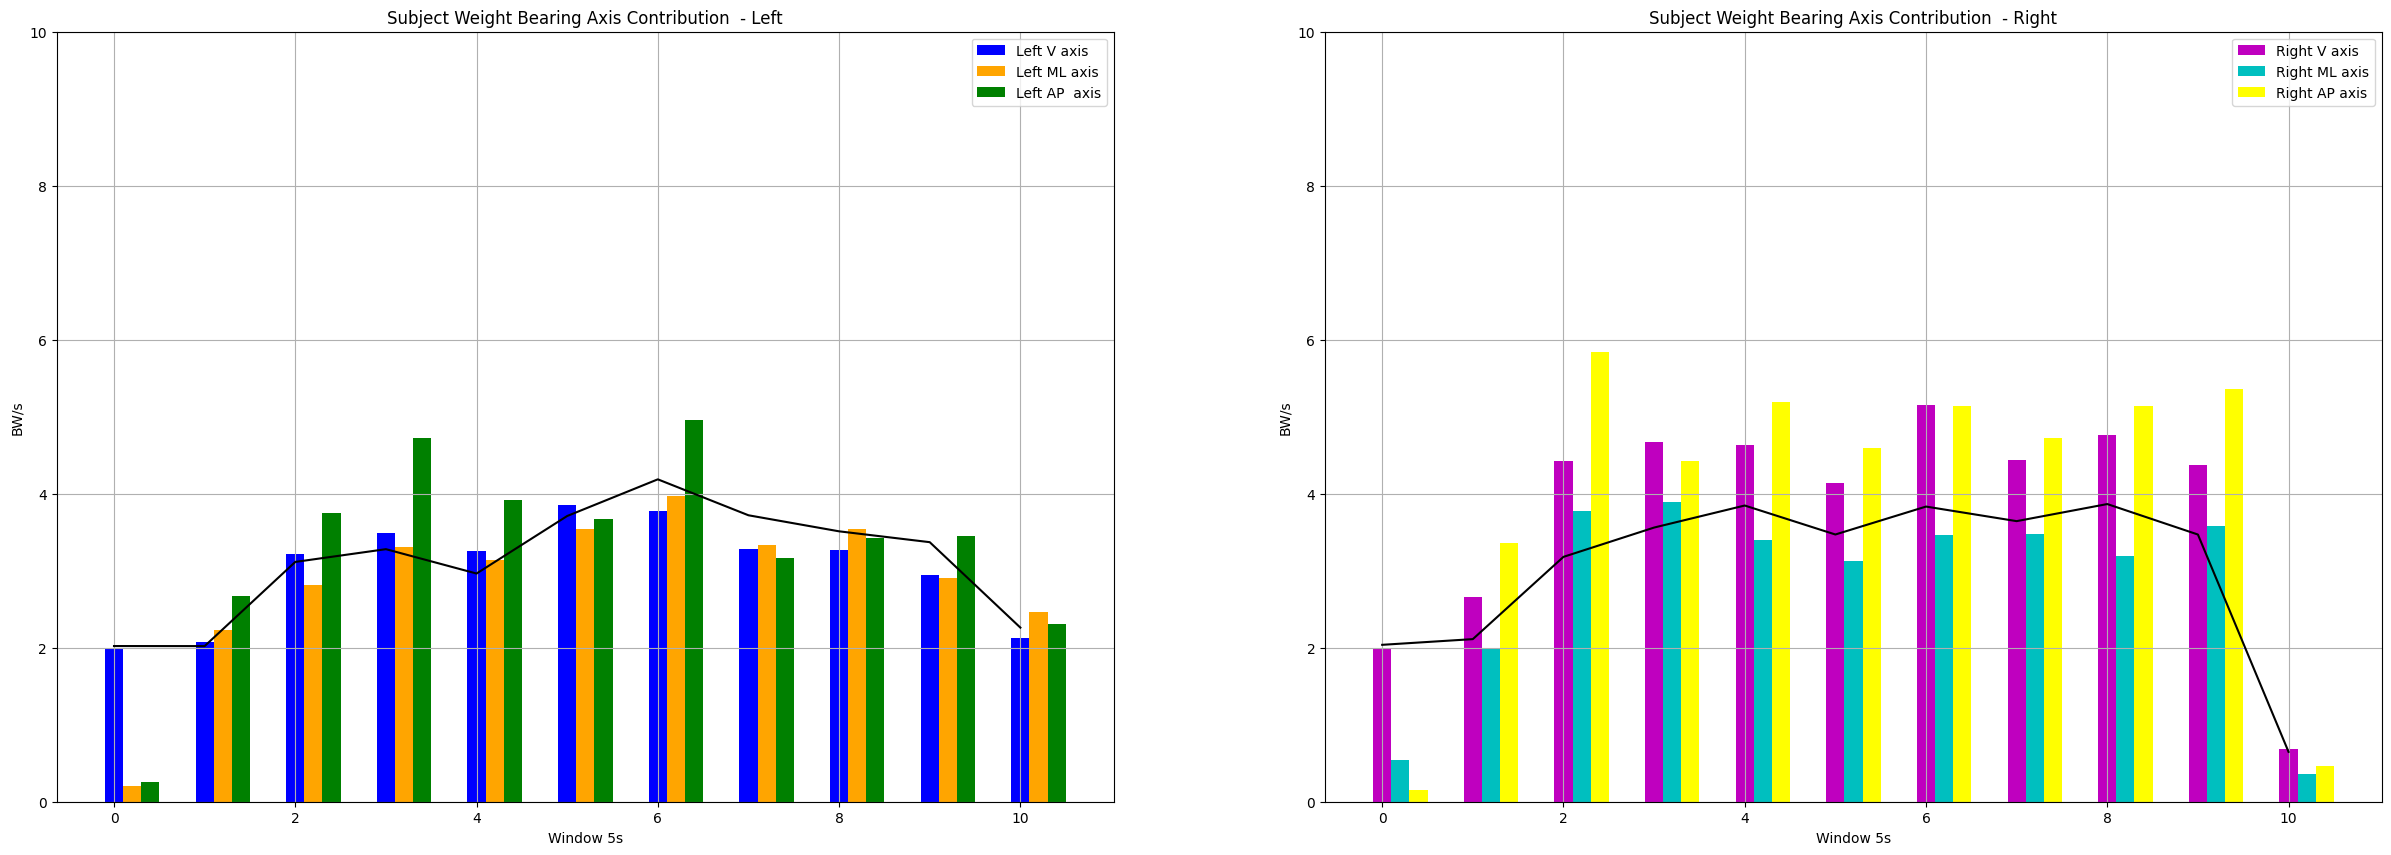

In [92]:
fig, ax = plt.subplots(1,2, figsize=(30, 10))

# time index
l_index_x = [i for i in range(len(l_axis_wb[0]))]
l_index_y = [i + 0.2 for i in range(len(l_axis_wb[1]))]
l_index_z = [i + 0.4 for i in range(len(l_axis_wb[2]))]

r_index_x = [i for i in range(len(r_axis_wb[0]))]
r_index_y = [i + 0.2 for i in range(len(r_axis_wb[1]))]
r_index_z = [i + 0.4 for i in range(len(r_axis_wb[2]))]

ax[0].bar(l_index_x, l_axis_wb[0],   0.2,  color="blue", label="Left V axis" )
ax[0].bar(l_index_y, l_axis_wb[1],   0.2,  color="orange", label="Left ML axis" )
ax[0].bar(l_index_z, l_axis_wb[2],   0.2,  color="green", label="Left AP  axis" )
ax[0].plot(np.arange(0, len(wb_left)), wb_left, color="black")

ax[1].bar(r_index_x, r_axis_wb[0],   0.2,  color="m", label="Right V axis" )
ax[1].bar(r_index_y, r_axis_wb[1],   0.2,  color="c", label="Right ML axis" )
ax[1].bar(r_index_z, r_axis_wb[2],   0.2,  color="yellow", label="Right AP axis" )
ax[1].plot(np.arange(0, len(wb_right)), wb_right, color="black")
# graph config

ax[0].set_title(f"Subject Weight Bearing Axis Contribution  - Left")
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlabel("Window 5s")
ax[0].set_ylim(0, 10)
ax[0].set_ylabel('BW/s')
ax[1].set_title(f"Subject Weight Bearing Axis Contribution  - Right")
ax[1].grid(True)
ax[1].legend()
ax[1].set_xlabel("Window 5s")
ax[1].set_ylim(0, 10)
ax[1].set_ylabel('BW/s')

### Basic stats for window loading

In [93]:
# average loading 
left_avg_wb = np.sum(wb_left) / len(wb_left)
print(f"average load left {left_avg_wb}")

right_avg_wb = np.sum(wb_right) / len(wb_right)
print(f"average load right {right_avg_wb}")

overall_wb = (left_avg_wb + right_avg_wb) / 2
print(f"overall capability {overall_wb}")

print()

# distribution
wb_in_left = (left_avg_wb / (left_avg_wb + right_avg_wb)) * 100
wb_in_right = (right_avg_wb / (left_avg_wb + right_avg_wb)) * 100

print(f"distribution - Left {wb_in_left}% Right {wb_in_right}%")
print(f"difference =  {abs(wb_in_left - wb_in_right)}")

print()


# axis contribution
# r_axis_wb, l_axis_wb are arrays of x,y,z
l_t_axis = np.mean([sum(elements) for elements in zip(*l_axis_wb)])
r_t_axis = np.mean([sum(elements) for elements in zip(*r_axis_wb)])

left_avg_axis = []
left_percent_contribution = []
for axis in l_axis_wb: # for each axis x, y, z
    #print(axis)
    ax_avg = round(np.sum(axis)/len(axis),2)
    left_avg_axis.append(ax_avg)
    left_percent_contribution.append(round((ax_avg/l_t_axis)*100,0))

right_avg_axis = []
right_percent_contribution = []
for axis in r_axis_wb:
    ax_avg = round(np.sum(axis)/len(axis),2)
    right_avg_axis.append(ax_avg)
    right_percent_contribution.append(round((ax_avg/r_t_axis)*100,0))

print(f"left:  V {left_avg_axis[0]} ML {left_avg_axis[1]} AP {left_avg_axis[2]}")
print(f"left contribution V {left_percent_contribution[0]}% ML {left_percent_contribution[1]}% AP {left_percent_contribution[2]}%")
print()
print(f"right:  V {right_avg_axis[0]} ML {right_avg_axis[1]} AP {right_avg_axis[2]}")
print(f"right contribution V {right_percent_contribution[0]}% ML {right_percent_contribution[1]}% AP {right_percent_contribution[2]}%")

average load left 3.105602708605772
average load right 3.060682960215509
overall capability 3.0831428344106406

distribution - Left 50.364236679930286% Right 49.63576332006971%
difference =  0.7284733598605797

left:  V 3.03 ML 2.86 AP 3.3
left contribution V 33.0% ML 31.0% AP 36.0%

right:  V 3.81 ML 2.8 AP 4.04
right contribution V 36.0% ML 26.0% AP 38.0%


### Frequency Response

In [94]:
# 1. vector magnitude
g=9.80665
left_mag = vector_magnitude([left_acc_x / g, left_acc_y / g, left_acc_z / g])
left_mag_filtered = filter_signal(b,a, left_mag, "filtfilt")
right_mag = vector_magnitude([right_acc_x / g, right_acc_y / g, right_acc_z / g])
right_mag_filtered = filter_signal(b,a, right_mag, "filtfilt")
# 2. compute fft graph (returns x,y)
left_fft = compute_frequency_response(left_mag_filtered, sampling_rate)
right_fft = compute_frequency_response(right_mag_filtered, sampling_rate)

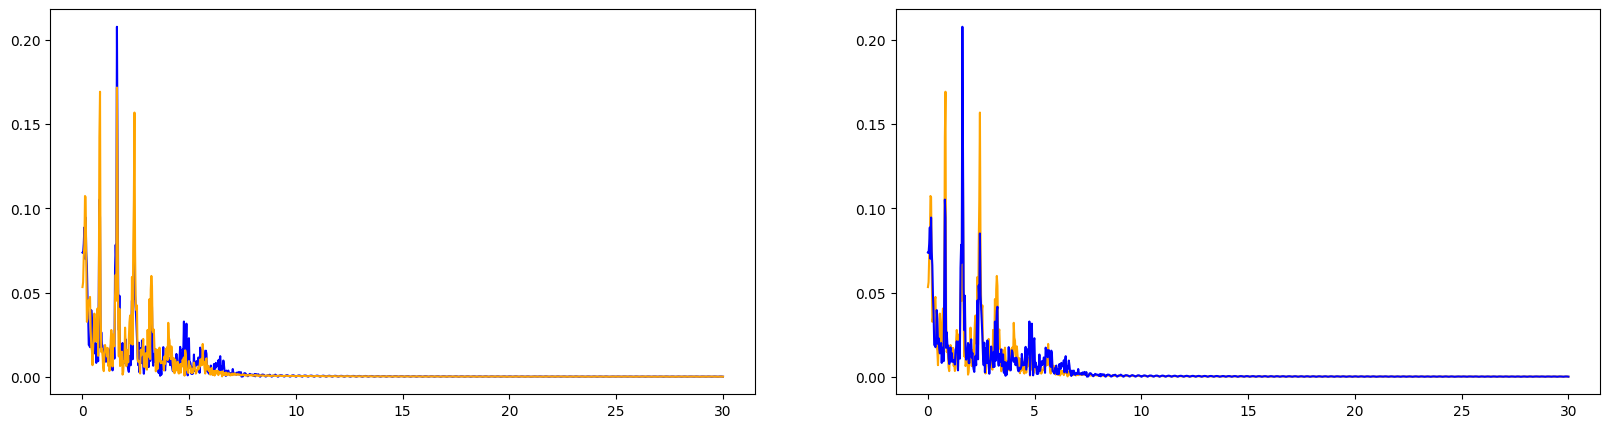

In [95]:
# 3. plot the graph
fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].plot(left_fft[0], left_fft[1], color="b")
ax[0].plot(right_fft[0], right_fft[1], color="orange")
ax[1].plot(right_fft[0], right_fft[1], color="orange")
ax[1].plot(left_fft[0], left_fft[1], color="b")

### Axial Frequency Respone

In [96]:
# can use the fft function above
def compute_axial_f_response(axis, sampling_rate):
    axis_fft_mag = compute_fft_mag(axis)
    graph = fft_graph_values(axis_fft_mag, sampling_rate)
    return graph

l_acc_x = filter_signal(b,a, left_acc_x / g, "filtfilt")
l_acc_y = filter_signal(b,a, left_acc_y / g, "filtfilt")
l_acc_z = filter_signal(b,a, left_acc_z / g, "filtfilt")

r_acc_x = filter_signal(b,a, right_acc_x / g, "filtfilt")
r_acc_y = filter_signal(b,a, right_acc_y / g, "filtfilt")
r_acc_z = filter_signal(b,a, right_acc_z / g, "filtfilt")

l_fft_x = compute_axial_f_response(l_acc_x, sampling_rate)
l_fft_y = compute_axial_f_response(l_acc_y, sampling_rate)
l_fft_z = compute_axial_f_response(l_acc_z, sampling_rate)

r_fft_x = compute_axial_f_response(r_acc_x, sampling_rate)
r_fft_y = compute_axial_f_response(r_acc_y, sampling_rate)
r_fft_z = compute_axial_f_response(r_acc_z, sampling_rate)


(0.0, 0.19884128534371368)

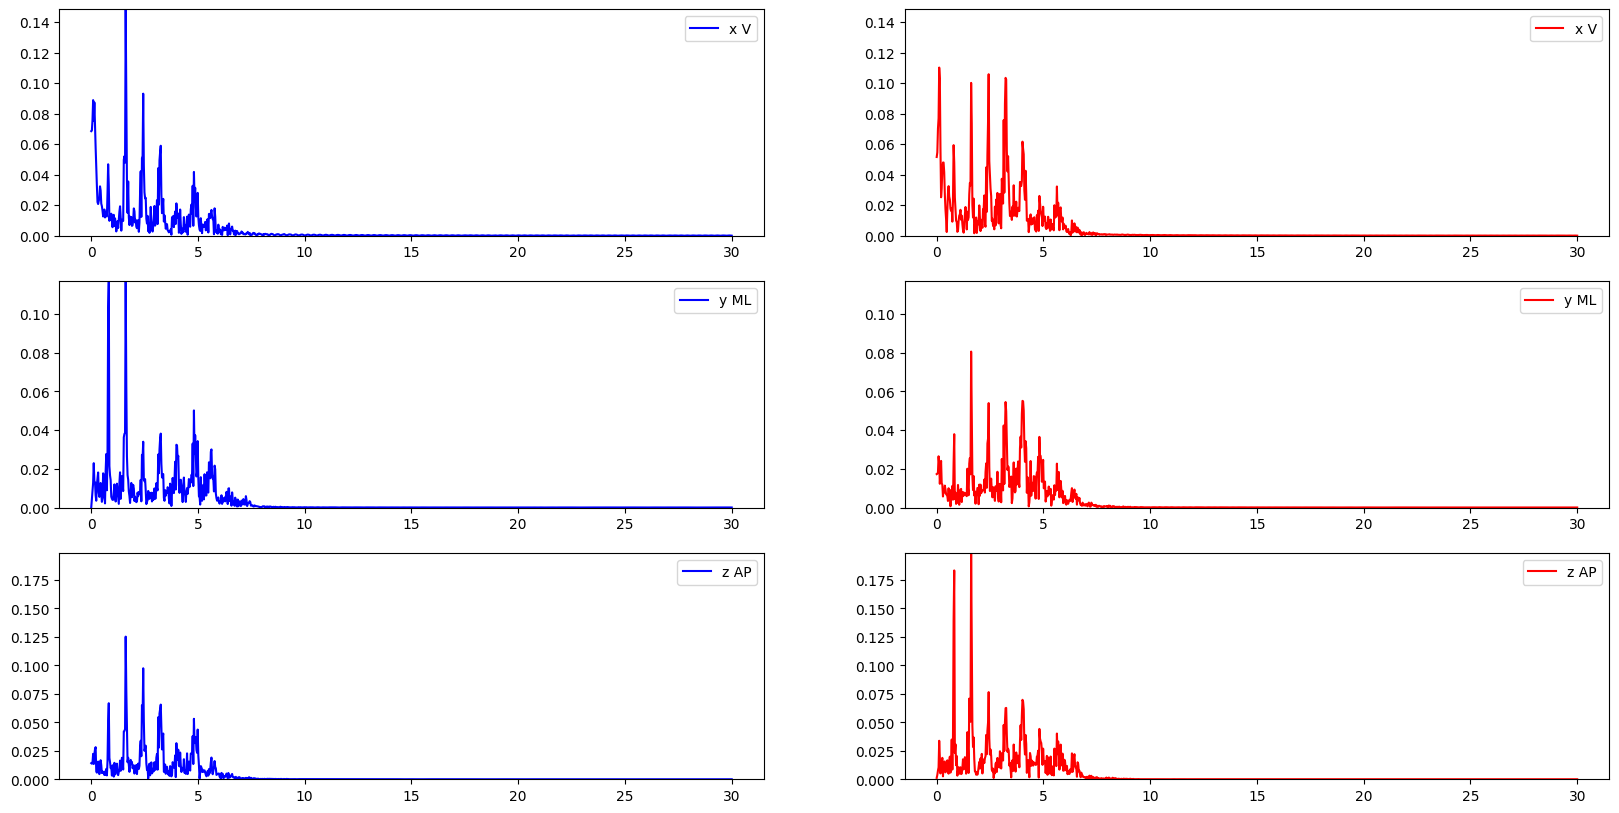

In [97]:
# plot axial f response
fig, ax = plt.subplots(3,2, figsize=(20, 10))
ax[0][0].plot(l_fft_x[0], l_fft_x[1], color="b", label="x V")
ax[1][0].plot(l_fft_y[0], l_fft_y[1], color="b", label="y ML")
ax[2][0].plot(l_fft_z[0], l_fft_z[1], color="b", label="z AP")

ax[0][1].plot(r_fft_x[0], r_fft_x[1], color="r", label="x V")
ax[1][1].plot(r_fft_y[0], r_fft_y[1], color="r", label="y ML")
ax[2][1].plot(r_fft_z[0], r_fft_z[1], color="r", label="z AP")

ax[0][0].legend()
ax[1][0].legend()
ax[2][0].legend()

ax[0][1].legend()
ax[1][1].legend()
ax[2][1].legend()

x_lim = max(max(l_fft_x[1]), max(r_fft_x[1]))
y_lim = max(max(l_fft_y[1]), max(r_fft_y[1]))
z_lim = max(max(l_fft_z[1]), max(r_fft_z[1]))

ax[0][0].set_ylim(0,x_lim)
ax[0][1].set_ylim(0,x_lim)

ax[1][0].set_ylim(0, y_lim)
ax[1][1].set_ylim(0, y_lim)

ax[2][0].set_ylim(0, z_lim)
ax[2][1].set_ylim(0, z_lim)

### Total Loading for Activity

In [98]:
# computes the loading intenisty for a complete activity
def compute_complete_weight_bearing(accel_x, accel_y, accel_z, sampling_rate, window, lc_off, hc_off, filter_order, filter_type):
    # build the filter
    b,a = build_filter((lc_off, hc_off), sampling_rate, filter_type, filter_order)
    
    accel_x = accel_x.to_numpy()  / 9.80665
    accel_y = accel_y.to_numpy()  / 9.80665
    accel_z = accel_z.to_numpy()  / 9.80665

    a_mag = vector_magnitude([accel_x, accel_y, accel_z])
    filtered_mag = filter_signal(b,a, a_mag, "filtfilt")
    fft_mag = compute_fft_mag(filtered_mag)
    li_result = compute_loading_intensity(fft_mag, sampling_rate, hc_off)
        
    return li_result

In [99]:
l_x = left_df["Acc_X"]
l_y = left_df["Acc_Y"]
l_z = left_df["Acc_Z"] 
r_x = right_df["Acc_X"]
r_y = right_df["Acc_Y"]
r_z = right_df["Acc_Z"] 

l_total = compute_complete_weight_bearing(l_x, l_y, l_z,
                sampling_rate, window, low_cut_off, high_cut_off, filter_order, filter_type) 
r_total = compute_complete_weight_bearing(r_x, r_y, r_z,
                sampling_rate, window, low_cut_off, high_cut_off, filter_order, filter_type) 

print(f"total L: {round(l_total,2)}, total R: {round(r_total,2)}")

total L: 8.55, total R: 8.89
